<a href="https://colab.research.google.com/github/Aafiya-H/Python-Sentiment-Analysis/blob/master/ulmfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd


path = '/content/drive/My Drive/Datasets/IMDB Dataset.csv'   #path for our dataset
save_path = '/content/drive/My Drive/Datasets/'  #path where we want to save the model.

data = pd.read_csv(path)


In [0]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [0]:
len(data)

50000

In [0]:
data=data[['review','sentiment']]
train_df=data.iloc[:10000]        #we take the first 10000 reviews for training.
test_df=data.iloc[10000:11000]   #1000 reviews are taken for the test set.

In [0]:
train_review = train_df['review']
train_label = train_df['sentiment']

test_review = test_df['review']
test_label = test_df['sentiment']

In [0]:

col_names = ['labels','text']
df_trn = pd.DataFrame({'text':train_review, 'labels':train_label}, columns=col_names)
df_val = pd.DataFrame({'text':test_review, 'labels':test_label}, columns=col_names)    

In [0]:
df_val.head()

,labels,text
6000,negative,This movie was an embarrassment. Ulma Thurman ...
6001,negative,This is one of the worst movies I've ever seen...
6002,negative,There is no doubt that Alfred Hitchcock was a ...
6003,positive,This is one of the best thrillers I've seen. I...
6004,positive,"My daughter, her friends and I have watched th..."


In [0]:
from fastai import *
from fastai.text import *

In [0]:
data_lm = TextLMDataBunch.from_df('./', train_df=df_trn, valid_df=df_val)  #TextLMDataBunch allows us to tokenize and pre-process the text data and formats it for a language model.

In [0]:
data_lm.show_batch()

idx,text
0,"this is not a show for the faint hearted or timid . xxmaj this show pulls no punches with regards to drugs , sex or violence . xxmaj its is hardcore , in the classic use of the word . \n \n xxmaj it is called xxup oz as that is the nickname given to the xxmaj oswald xxmaj maximum xxmaj security xxmaj state xxmaj xxunk . xxmaj it"
1,"it to be done with , for the ' i hate women ' mantra to ease up or be rid altogether . xxbos xxmaj the few scenes that actually attempt a depiction of revolutionary struggle resemble a xxunk xxmaj boy xxmaj scout troop meandering tentatively between swimming holes . xxmaj when xxmaj sharif or , please xxmaj god , xxmaj palance try their hand at fiery xxunk , they sound"
2,"lot to the film . xxmaj his narration has a friendly feel that fits the picture perfectly . xxmaj as a director , he is restrained and calm , and captures some incredibly beautiful scenes . xxmaj as for the acting , xxmaj craig xxmaj sheffer and xxmaj brad xxmaj pitt work surprising well as brothers . i do n't know quite how to describe xxmaj tom xxmaj skerritt and"
3,"that because whenever i have watched her perform , the characters thus far , in each portrayal she also seemed to have her own persona that lived with that character , quite nicely in fact . \n \n xxmaj anyway , my first film experience with xxmaj reese was the xxmaj little xxmaj red xxmaj riding xxmaj hood parody xxmaj reese did with xxmaj kiefer xxmaj sutherland , somehow"
4,"excellent , and are the main reason why i 'm rating this a 4 . \n \n xxmaj in this version , xxmaj sara is a little too self - sacrificing for my taste . xxmaj there is no way she would have deliberately lied to xxmaj miss xxmaj xxunk just to stop her punishing the other girls ; in the book she makes a point of describing lies"


In [0]:
learner = language_model_learner(data_lm,AWD_LSTM)  # here we set our language model to AWD_LSTM which is  the architecture for ULMFiT.

In [0]:
learner.lr_find()  # lr_find finds the learning rate with respect to loss. After this we need to plot a graph so that we can check what learning rate we should use.

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


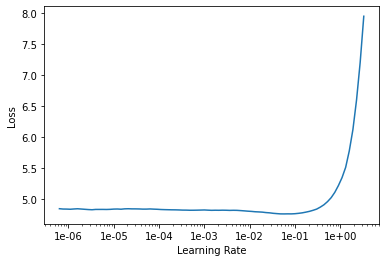

In [0]:
learner.recorder.plot()

In [0]:
learner.unfreeze()   #We are unfreezing the model so that we can train it on our dataset.
learner.fit_one_cycle(1,1e-4)  #The model is trained for one epoch with a learning rate of 1e-4.

epoch,train_loss,valid_loss,accuracy,time
0,4.565799,4.182315,0.279825,01:00


In [0]:
learner.save_encoder(save_path+'tuned_enc')  #We need to save the language model so that we can use  it later for classification.

In [0]:
classification_data = TextClasDataBunch.from_df('./', train_df=df_trn, valid_df=df_val,vocab = data_lm.train_ds.vocab,bs = 32) # we need to include the labels as well since TextClasDataBunch will format the data for classification.

In [0]:
classifier = text_classifier_learner(classification_data,AWD_LSTM)  #here too , our main architecture will be ULMFit i.e. AWD_LSTM.

In [0]:
classifier.load_encoder(save_path+'tuned_enc')  #we load our saved language model into the classifier.

In [0]:
classifier.lr_find() #similar procedure to find the learning rate.

epoch,train_loss,valid_loss,accuracy,time


In [0]:
classifier.recorder.plot() #we plot the losses with respect to the learning rate.

In [0]:
classifier.fit_one_cycle(2,1e-1)  #here we run the model for two epochs with a learning rate of 1e-1.

In [0]:
classifier.recorder.plot_losses()  

In [0]:
import pickle

classifier.save('ulmfit_model',return_path = True) #finally , we save  our trained model and in the below cell , we pickle it so that it can be used else where.

In [0]:
classifier.export(save_path + 'ulmfit_model.pkl')